In [1]:
%load_ext autoreload
%autoreload 2

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import json
import numpy as np
from pbo.utils.params import load_params
from pbo.utils.confidence_interval import confidence_interval
from pbo.sample_collection.replay_buffer import ReplayBuffer
from pbo.sample_collection.dataloader import SampleDataLoader


experiment_name = "q1"
show_fqi = True; show_pbo_linear = False; show_pbo_deep = True; show_ifqi = True
max_bellman_iterations = 9
max_bellman_iterations_validation = max_bellman_iterations + 10
seeds = range(1, 21)

p = json.load(open(f"figures/{experiment_name}/parameters.json"))

n_states_x = p["n_states_x"]
n_states_v = p["n_states_v"]
n_seeds = len(seeds)
ticks_freq = 3 if max_bellman_iterations == 6 else 5

### Extract data

In [2]:
if show_fqi:
    fqi_params = []

    for idx_seed, seed in enumerate(seeds):
        fqi_params.append(load_params(f"figures/{experiment_name}/FQI/{max_bellman_iterations}_P_{seed}"))

if show_pbo_linear:
    pbo_linear_params = []

    for idx_seed, seed in enumerate(seeds):
        pbo_linear_params.append(load_params(f"figures/{experiment_name}/PBO_linear/{max_bellman_iterations}_P_{seed}"))

if show_pbo_deep:
    pbo_deep_params = []

    for idx_seed, seed in enumerate(seeds):
        pbo_deep_params.append(load_params(f"figures/{experiment_name}/PBO_deep/{max_bellman_iterations}_P_{seed}"))

if show_ifqi:
    ifqi_params = []

    for idx_seed, seed in enumerate(seeds):
        ifqi_params.append(load_params(f"figures/{experiment_name}/IFQI/{max_bellman_iterations}_P_{seed}"))

replay_buffer = ReplayBuffer()
replay_buffer.load(f"figures/{experiment_name}/replay_buffer.npz")
data_loader_samples = SampleDataLoader(replay_buffer, len(replay_buffer), None)

### Compute approximation errors and speed

In [3]:
import jax 

from experiments.car_on_hill.utils import define_environment
from pbo.networks.learnable_q import FullyConnectedQ

env, _, _, _, _ = define_environment(p["gamma"], p["n_states_x"], p["n_states_v"])
q = FullyConnectedQ(
    state_dim=2,
    action_dim=1,
    actions_on_max=env.actions_on_max,
    gamma=p["gamma"],
    network_key=jax.random.PRNGKey(0),
    layers_dimension=p["layers_dimension"],
    zero_initializer=True,
    learning_rate={"first": 0, "last": 0, "duration": 0},
)

In [4]:
if show_fqi:
    fqi_approximation_errors = np.ones((n_seeds, max_bellman_iterations)) * np.nan
    fqi_speed = np.ones((n_seeds, max_bellman_iterations)) * np.nan

    for idx_seed in range(n_seeds):
        for iteration in range(1, max_bellman_iterations + 1):
            fqi_approximation_errors[idx_seed, iteration - 1] = q.loss(fqi_params[idx_seed][f"{iteration}"], fqi_params[idx_seed][f"{iteration - 1}"], data_loader_samples[0])
            fqi_speed[idx_seed, iteration - 1] = np.linalg.norm(q.to_weights(fqi_params[idx_seed][f"{iteration}"]) - q.to_weights(fqi_params[idx_seed][f"{iteration - 1}"]))

In [5]:
if show_pbo_linear:
    from pbo.networks.learnable_pbo import LinearPBO


    pbo_linear = LinearPBO(
                q=q,
                max_bellman_iterations=max_bellman_iterations,
                add_infinity=False,
                network_key=jax.random.PRNGKey(0),
                learning_rate={"first": 0, "last": 0, "duration": 0},
                initial_weight_std=p["initial_weight_std"],
            )
    pbo_linear_approximation_errors = np.ones((n_seeds, max_bellman_iterations_validation)) * np.nan
    pbo_linear_speed = np.ones((n_seeds, max_bellman_iterations_validation)) * np.nan

    for idx_seed in range(n_seeds):
        pbo_linear.params = pbo_linear_params[idx_seed]
        q_weights_iteration_minus_1 = q.to_weights(fqi_params[idx_seed]["0"])
        q_weights_iteration = pbo_linear(pbo_linear.params, q_weights_iteration_minus_1.reshape((1, -1)))[0]

        for iteration in range(1, max_bellman_iterations_validation + 1):
            pbo_linear_approximation_errors[idx_seed, iteration - 1] = q.loss(q.to_params(q_weights_iteration), q.to_params(q_weights_iteration_minus_1), data_loader_samples[0])
            pbo_linear_speed[idx_seed, iteration - 1] = np.linalg.norm(q_weights_iteration - q_weights_iteration_minus_1)

            q_weights_iteration_minus_1 = q_weights_iteration
            q_weights_iteration = pbo_linear(pbo_linear.params, q_weights_iteration_minus_1.reshape((1, -1)))[0]

In [6]:
if show_pbo_deep:
    from pbo.networks.learnable_pbo import DeepPBO


    pbo_deep = DeepPBO(
                    q=q,
                    max_bellman_iterations=max_bellman_iterations,
                    network_key=jax.random.PRNGKey(0),
                    layers_dimension=p["pbo_layers_dimension"],
                    learning_rate={"first": 0, "last": 0, "duration": 0},
                    initial_weight_std=0.1,
                )
    pbo_deep_approximation_errors = np.ones((n_seeds, max_bellman_iterations_validation)) * np.nan
    pbo_deep_speed = np.ones((n_seeds, max_bellman_iterations_validation)) * np.nan

    for idx_seed in range(n_seeds):
        pbo_deep.params = pbo_deep_params[idx_seed]
        q_weights_iteration_minus_1 = q.to_weights(fqi_params[idx_seed]["0"])
        q_weights_iteration = pbo_deep(pbo_deep.params, q_weights_iteration_minus_1.reshape((1, -1)))[0]

        for iteration in range(1, max_bellman_iterations_validation + 1):
            pbo_deep_approximation_errors[idx_seed, iteration - 1] = q.loss(q.to_params(q_weights_iteration), q.to_params(q_weights_iteration_minus_1), data_loader_samples[0])
            pbo_deep_speed[idx_seed, iteration - 1] = np.linalg.norm(q_weights_iteration - q_weights_iteration_minus_1)

            q_weights_iteration_minus_1 = q_weights_iteration
            q_weights_iteration = pbo_deep(pbo_deep.params, q_weights_iteration_minus_1.reshape((1, -1)))[0]

In [7]:
if show_ifqi:
    from pbo.networks.learnable_multi_head_q import FullyConnectedMultiHeadQ


    multi_head = FullyConnectedMultiHeadQ(
            n_heads=max_bellman_iterations + 1,
            state_dim=2,
            action_dim=1,
            actions_on_max=env.actions_on_max,
            gamma=p["gamma"],
            network_key=jax.random.PRNGKey(0),
            layers_dimension=p["layers_dimension"],
            zero_initializer=True,
            learning_rate={"first": 0, "last": 0, "duration": 0},
        )
    ifqi_approximation_errors = np.ones((n_seeds, max_bellman_iterations)) * np.nan
    ifqi_speed = np.ones((n_seeds, max_bellman_iterations)) * np.nan

    for idx_seed in range(n_seeds):
        target = multi_head.compute_target(ifqi_params[idx_seed], data_loader_samples[0])

        ifqi_approximation_errors[idx_seed] = np.square(multi_head(ifqi_params[idx_seed], data_loader_samples[0]["state"], data_loader_samples[0]["action"])[:, 1:] - target[:, :-1]).mean(axis=0)

        for iteration in range(1, max_bellman_iterations + 1):
            params_iteration_minus_1 = {
                "FullyConnectedNet/linear_1": ifqi_params[idx_seed][f"FullyConnectedNet/head_{iteration - 1}_linear_1"],
                "FullyConnectedNet/linear_last": ifqi_params[idx_seed][f"FullyConnectedNet/head_{iteration - 1}_linear_last"],
            }
            params_iteration = {
                "FullyConnectedNet/linear_1": ifqi_params[idx_seed][f"FullyConnectedNet/head_{iteration}_linear_1"],
                "FullyConnectedNet/linear_last": ifqi_params[idx_seed][f"FullyConnectedNet/head_{iteration}_linear_last"],
            }
            ifqi_speed[idx_seed, iteration - 1] = np.linalg.norm(q.to_weights(params_iteration) - q.to_weights(params_iteration_minus_1))

### Plot approximation erros

In [8]:
if show_fqi:
    fqi_mean = fqi_approximation_errors.mean(axis=0)
    fqi_std = fqi_approximation_errors.std(axis=0)
    fqi_confidence_interval = confidence_interval(fqi_mean, fqi_std, n_seeds)

if show_pbo_linear:
    pbo_linear_mean = pbo_linear_approximation_errors.mean(axis=0)
    pbo_linear_std = pbo_linear_approximation_errors.std(axis=0)
    pbo_linear_confidence_interval = confidence_interval(pbo_linear_mean, pbo_linear_std, n_seeds)

if show_pbo_deep:
    pbo_deep_mean = pbo_deep_approximation_errors.mean(axis=0)
    pbo_deep_std = pbo_deep_approximation_errors.std(axis=0)
    pbo_deep_confidence_interval = confidence_interval(pbo_deep_mean, pbo_deep_std, n_seeds)

if show_ifqi:
    ifqi_mean = ifqi_approximation_errors.mean(axis=0)
    ifqi_std = ifqi_approximation_errors.std(axis=0)
    ifqi_confidence_interval = confidence_interval(ifqi_mean, ifqi_std, n_seeds)

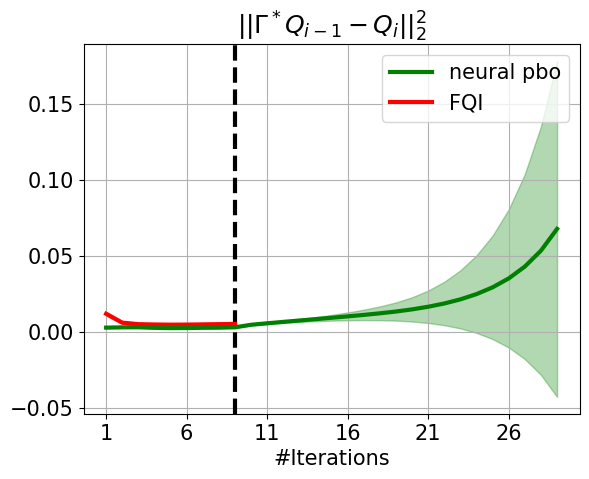

In [9]:
import matplotlib.pyplot as plt 

plt.rc("font", size=15)
plt.rc("lines", linewidth=3)

iterations = range(1, max_bellman_iterations + 1)
iterations_validation = range(1, max_bellman_iterations_validation + 1)

if show_pbo_linear:
    plt.plot(iterations_validation, pbo_linear_mean, label="linear pbo", color="blue", zorder=7)
    plt.fill_between(iterations_validation, pbo_linear_confidence_interval[0], pbo_linear_confidence_interval[1], color="blue", alpha=0.3)

if show_pbo_deep:
    plt.plot(iterations_validation, pbo_deep_mean, label="neural pbo", color="green", zorder=8)
    plt.fill_between(iterations_validation, pbo_deep_confidence_interval[0], pbo_deep_confidence_interval[1], color="green", alpha=0.3)

if show_fqi:
    plt.plot(iterations, fqi_mean, label="FQI", color="red", zorder=6)
    plt.fill_between(iterations, fqi_confidence_interval[0], fqi_confidence_interval[1], color="red", alpha=0.3)

if show_ifqi:
    plt.plot(iterations, ifqi_mean, label="IFQI", color="yellow", zorder=6)
    plt.fill_between(iterations, ifqi_confidence_interval[0], ifqi_confidence_interval[1], color="yellow", alpha=0.3)


plt.axvline(max_bellman_iterations, color="black", linestyle="--", zorder=2)
plt.xticks(range(1, max_bellman_iterations_validation + 1, ticks_freq))
plt.xlabel("#Iterations")
plt.title(r"$|| \Gamma^*Q_{i-1} - Q_i ||_2^2$")
plt.legend().set_zorder(9)
plt.grid(zorder=0)
_ = plt.savefig(f"figures/{experiment_name}/approximation_errors_{max_bellman_iterations}.pdf", bbox_inches='tight')

### Plot speed

In [10]:
if show_fqi:
    fqi_speed_mean = fqi_speed.mean(axis=0)
    fqi_spped_std = fqi_speed.std(axis=0)
    fqi_speed_confidence_interval = confidence_interval(fqi_speed_mean, fqi_spped_std, n_seeds)

if show_pbo_linear:
    pbo_linear_speed_mean = pbo_linear_speed.mean(axis=0)
    pbo_linear_spped_std = pbo_linear_speed.std(axis=0)
    pbo_linear_speed_confidence_interval = confidence_interval(pbo_linear_speed_mean, pbo_linear_spped_std, n_seeds)

if show_pbo_deep:
    pbo_deep_speed_mean = pbo_deep_speed.mean(axis=0)
    pbo_deep_spped_std = pbo_deep_speed.std(axis=0)
    pbo_deep_speed_confidence_interval = confidence_interval(pbo_deep_speed_mean, pbo_deep_spped_std, n_seeds)

if show_ifqi:
    ifqi_speed_mean = ifqi_speed.mean(axis=0)
    ifqi_spped_std = ifqi_speed.std(axis=0)
    ifqi_speed_confidence_interval = confidence_interval(ifqi_speed_mean, ifqi_spped_std, n_seeds)

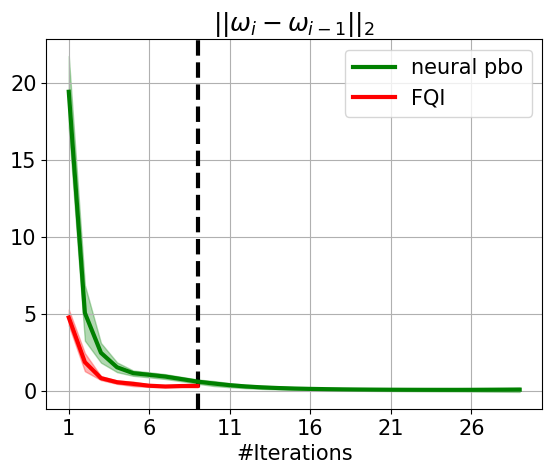

In [11]:
import matplotlib.pyplot as plt 

plt.rc("font", size=15)
plt.rc("lines", linewidth=3)

iterations = range(1, max_bellman_iterations + 1)
iterations_validation = range(1, max_bellman_iterations_validation + 1)

if show_pbo_linear:
    plt.plot(iterations_validation, pbo_linear_speed_mean, label="linear pbo", color="blue", zorder=7)
    plt.fill_between(iterations_validation, pbo_linear_speed_confidence_interval[0], pbo_linear_speed_confidence_interval[1], color="blue", alpha=0.3)

if show_pbo_deep:
    plt.plot(iterations_validation, pbo_deep_speed_mean, label="neural pbo", color="green", zorder=8)
    plt.fill_between(iterations_validation, pbo_deep_speed_confidence_interval[0], pbo_deep_speed_confidence_interval[1], color="green", alpha=0.3)

if show_fqi:
    plt.plot(iterations, fqi_speed_mean, label="FQI", color="red", zorder=6)
    plt.fill_between(iterations, fqi_speed_confidence_interval[0], fqi_speed_confidence_interval[1], color="red", alpha=0.3)

if show_ifqi:
    plt.plot(iterations, ifqi_speed_mean, label="IFQI", color="yellow", zorder=6)
    plt.fill_between(iterations, ifqi_speed_confidence_interval[0], ifqi_speed_confidence_interval[1], color="yellow", alpha=0.3)


plt.axvline(max_bellman_iterations, color="black", linestyle="--", zorder=2)
plt.xticks(range(1, max_bellman_iterations_validation + 1, ticks_freq))
plt.xlabel("#Iterations")
plt.title(r"$|| \omega_i - \omega_{i-1} ||_2$")
plt.legend().set_zorder(9)
plt.grid(zorder=0)
_ = plt.savefig(f"figures/{experiment_name}/speed_{max_bellman_iterations}.pdf", bbox_inches='tight')